In [ ]:
!pip install torch torchvision
!pip install transformers==2.2.0
#!pip install transformers
!pip install seqeval
!pip install tensorboardx
!pip install simpletransformers==0.9.1
#!pip install --upgrade simpletransformers

     |████████████████████████████████| 368kB 8.9MB/s 
     |████████████████████████████████| 133kB 52.2MB/s 
     |████████████████████████████████| 7.2MB 50.2MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
ERROR: simpletransformers 0.51.13 has requirement transformers>=4.0.0, but you'll have transformers 2.2.0 which is incompatible.
ERROR: botocore 1.19.59 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: transformers 4.2.2
    Uninstalling transformers-4.2.2:
      Successfully uninstalled transformers-4.2.2
     |████████████████████████████████| 71kB 4.9MB/s 
  Found existing installation: simpletransformers 0.51.13
    Uninstalling simpletransformers-0.51.13:
      Successfully uninstalled simpletransformers-0.51.13


In [ ]:
## Import required libraries
%matplotlib inline

import pandas as pd
import numpy as np

import gc
import requests
import os
import io
from google.colab import drive 
import datetime
from simpletransformers.classification import ClassificationModel

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn import preprocessing 

import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.7.0+cu101


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sns
import re

In [ ]:
 
## dataset-2
drive.mount('/content/gdrive')

df=pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/Corona/corona_fake.csv')

print(df.head())



Mounted at /content/gdrive
                                               title  ... label1
0  Due to the recent outbreak for the Coronavirus...  ...      1
1                                                NaN  ...      1
2                                                NaN  ...      1
3                                                NaN  ...      1
4                                                NaN  ...      1

[5 rows x 5 columns]


In [ ]:

df1 = df[['title', 'label1']]

df1['title'] = df1['title'].str.lower()


#label_encoder = preprocessing.LabelEncoder() 
#train_df['label-liar']= label_encoder.fit_transform(train_df['label-liar'])
#eval_df['label-liar']= label_encoder.fit_transform(eval_df['label-liar']) 
print(df1.head())


                                               title  label1
0  due to the recent outbreak for the coronavirus...       1
1                                                NaN       1
2                                                NaN       1
3                                                NaN       1
4                                                NaN       1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df2 = df1[~df1['title'].isna()][['title','label1']]

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 1163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1082 non-null   object
 1   label1  1082 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.4+ KB


In [ ]:
df2.drop_duplicates(subset=['title'],keep='first',inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 1163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   969 non-null    object
 1   label1  969 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 22.7+ KB


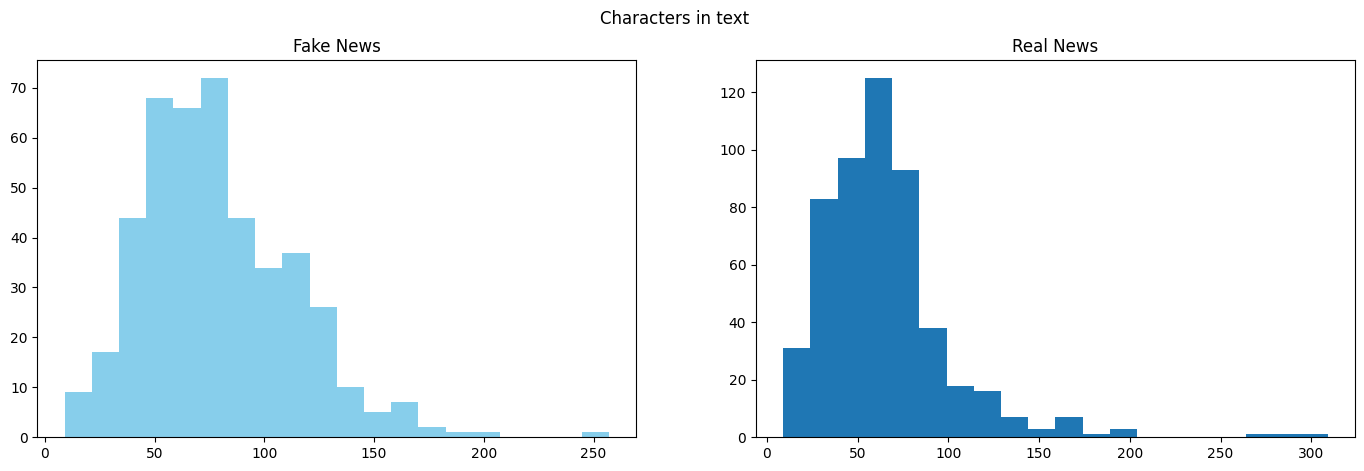

In [ ]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=df2[df2["label1"]==1]['title'].str.len()
ax1.hist(length,bins = 20,color='skyblue')
ax1.set_title('Fake News')
length=df2[df2["label1"]==0]['title'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real News')
fig.suptitle('Characters in text')
plt.show()

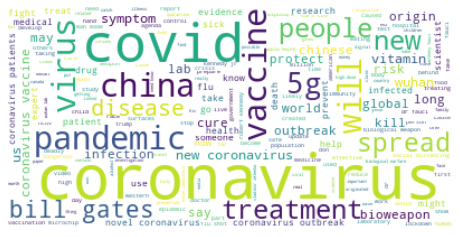

In [ ]:
text = " ".join([x for x in df2.title])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

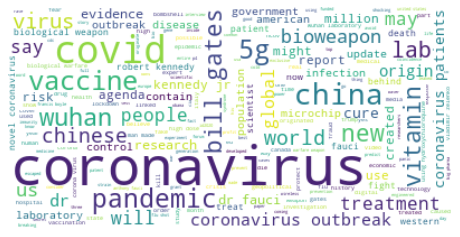

In [ ]:
## for fake

text = " ".join([x for x in df2.title[df2['label1']==1]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

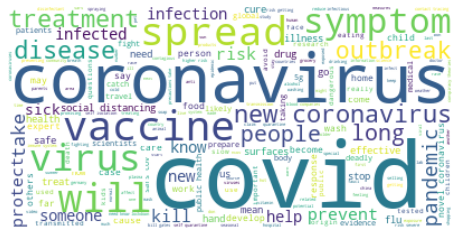

In [ ]:
## for real

text = " ".join([x for x in df2.title[df2['label1']==0]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
print('Number of 0 (Not Fake) : ', df2["label1"].value_counts()[0])
print('Number of 1 (Fake) : ', df2["label1"].value_counts()[1])

Number of 0 (Not Fake) :  525
Number of 1 (Fake) :  444


In [ ]:
# Dataset Preprocessing
def text_cleaning(text):
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    return text

df2['title'] = df2['title'].apply(text_cleaning)

In [45]:
# train test split
train, test = train_test_split(df2, test_size=0.3, random_state=42)

In [46]:
from simpletransformers.classification import ClassificationModel


# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2,
                            args={'reprocess_input_data': True, 'overwrite_output_dir': True,'fp16': False,'num_train_epochs': 4},use_cuda=True)


In [47]:
start=datetime.datetime.now()
model.train_model(train)
end=datetime.datetime.now()

exec_time=end-start
print("execution time:", exec_time)


Converting to features started.


  0%|          | 0/678 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Current iteration:   0%|          | 0/85 [00:00<?, ?it/s]

Running loss: 0.584696

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.158080

Current iteration:   0%|          | 0/85 [00:00<?, ?it/s]

Running loss: 0.051185

Current iteration:   0%|          | 0/85 [00:00<?, ?it/s]

Running loss: 0.011097

Current iteration:   0%|          | 0/85 [00:00<?, ?it/s]

Running loss: 0.007276Training of bert model complete. Saved to outputs/.
execution time: 0:01:21.106426


In [48]:
result, model_outputs, wrong_predictions = model.eval_model(test)

Converting to features started.


  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [49]:
print(result)
print(model_outputs)

{'mcc': 0.6368185974788003, 'tp': 101, 'tn': 138, 'fp': 25, 'fn': 27, 'eval_loss': 0.7657761824619327}
[[ 3.0792136  -3.8681962 ]
 [-1.6082498   1.3416842 ]
 [-3.2446103   2.7643511 ]
 [-3.0568047   2.5609174 ]
 [-2.84432     2.3796632 ]
 [ 3.034642   -3.8086336 ]
 [-0.40783364  0.06750409]
 [ 0.5904416  -1.0317605 ]
 [ 3.0736392  -3.8411448 ]
 [ 3.2820067  -3.5716302 ]
 [ 2.6255844  -2.7812696 ]
 [-1.4665664   1.3686395 ]
 [ 3.1007192  -3.7665813 ]
 [ 2.9806323  -3.7762012 ]
 [ 2.128126   -2.2812588 ]
 [-3.2450922   2.7113292 ]
 [ 3.1471882  -3.7994678 ]
 [-1.0936809   0.7283828 ]
 [ 2.9660559  -3.9037035 ]
 [ 3.1143968  -3.8696787 ]
 [ 3.236087   -3.7909667 ]
 [-0.7849902   0.37371665]
 [ 1.7046243  -2.2646642 ]
 [-3.1757169   2.7223074 ]
 [ 3.2837708  -3.8348482 ]
 [-2.9625351   2.5799541 ]
 [-2.8577156   2.3758976 ]
 [-2.9847012   2.4462497 ]
 [ 3.1879368  -3.8455148 ]
 [ 3.1565192  -3.9426014 ]
 [ 3.2988443  -3.5842147 ]
 [-2.8016605   2.3807647 ]
 [ 1.6742997  -1.9472861 ]
 [ 0.5

In [50]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [51]:
true = test['label1'].tolist()
predicted = lst

In [52]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
mat

array([[138,  25],
       [ 27, 101]])

In [53]:
print(sklearn.metrics.classification_report(true,predicted))


              precision    recall  f1-score   support

           0       0.84      0.85      0.84       163
           1       0.80      0.79      0.80       128

    accuracy                           0.82       291
   macro avg       0.82      0.82      0.82       291
weighted avg       0.82      0.82      0.82       291

